# FROMAGe Inference Example

Для инференса я использую ноутбук, предложенный авторами статьи, только поменяю немного в нем промпты. Ноутбук запускается из клона репозитория авторов при установке визуальных эмбеддингов для обучающей выборки (их нет в github, ссылка на скачивание (здесь)[https://drive.google.com/file/d/1wMojZNqEwApNlsCZVvSgQVtZLgbeLoKi/view?usp=share_link]). После скачивания их необходимо сохранить в папку fromage_model в клоне репозитория для корректной работы блокнота в инференсе.

Обращаю внимание, что репозиторий авторов не устанавливается по pip. Нужно делать именно клон всего репозитория или копировать скрипты.

In [1]:
#!g2.1
import numpy as np
import copy
import torch
from transformers import logging
logging.set_verbosity_error()

from PIL import Image
%pip install matplotlib
import matplotlib.pyplot as plt

from fromage import models
from fromage import utils

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


Функции, предложенные авторами для вывода ответов модели:

In [2]:
#!g2.1
def trunc_caption(caption: str) -> str:
    # Truncate at period.
    trunc_index = caption.find('.') + 1
    if trunc_index < 0:
        trunc_index = caption.find('\n') + 1
    caption = caption[:trunc_index]
    return caption

def display_interleaved_outputs(model_outputs, one_img_per_ret=True):
    for output in model_outputs:
        if type(output) == str:
            print(output)
        elif type(output) == list:
            if one_img_per_ret:
                plt.figure(figsize=(3, 3))
                plt.imshow(np.array(output[0]))
            else:
                fig, ax = plt.subplots(1, len(output), figsize=(3 * len(output), 3))
                for i, image in enumerate(output):
                    image = np.array(image)
                    ax[i].imshow(image)
                    ax[i].set_title(f'Retrieval #{i+1}')
            plt.show()
        elif type(output) == Image.Image:
            plt.figure(figsize=(3, 3))
            plt.imshow(np.array(output))
            plt.show()

In [3]:
#!g2.1
from huggingface_hub import notebook_login
notebook_login()

### Load Model and Embedding Matrix

Загрузка модели возможна только если в папке есть эмббединги обучающей выборки

In [4]:
#!g2.1
# Load model used in the paper.
model_dir = './fromage_model/'
model = models.load_fromage(model_dir)

2023-11-08 14:40:08.873953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using HuggingFace AutoFeatureExtractor for openai/clip-vit-large-patch14.
Using facebook/opt-6.7b for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 1 visual tokens.
Freezing the LM.
Initializing embedding for the retrieval token [RET] (id = 50266).
Restoring pretrained weights for the visual model.
Freezing the VM.


### Вариант 1 генерации - по промпту в виде изображения

В качестве задание на ретривал подается таргетное изображение и описание. При этом само изображение нигде не упоминается. Модель сама находит максимально похожие из обучающей выборки. В качестве таргентного изображения возьму собаку в парке их задания на inpaint :)

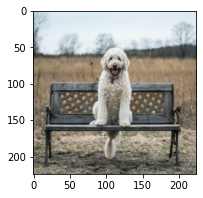

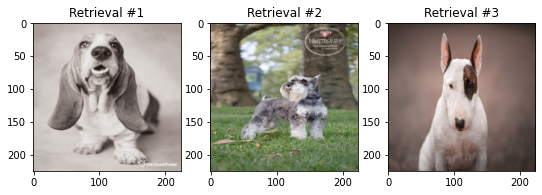

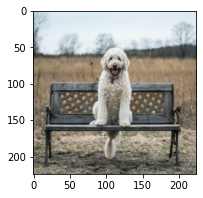

Prompt:
watercolor drawing [RET]
Model generated outputs:
watercolor drawing  [RET]
Prompt:
vector icon [RET]
Model generated outputs:
vector icon  [RET]


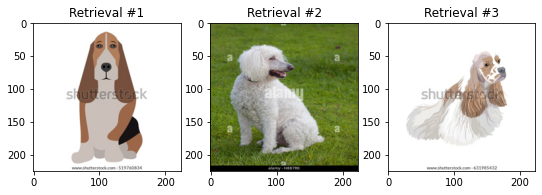

In [5]:
#!g2.1
# Загружаем референс
inp_image = utils.get_image_from_url('https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png')

# Задание на вывод результатов.
for inp_text in ['watercolor drawing [RET]', 'vector icon [RET]']:
    prompt = [inp_image, inp_text]
    print('Prompt:')
    display_interleaved_outputs(prompt)
    print('=' * 30)
    model_outputs = model.generate_for_images_and_texts(prompt, max_img_per_ret=3)

    # Display outputs.
    print('Model generated outputs:')
    display_interleaved_outputs(model_outputs, one_img_per_ret=False)

### Вариант 2 - мультимодальный диалог

Модель способна вести мультимодальный диалог и строить выводы на основе визуальных данных.

#### Example #1: Диалог о зебре (text inputs, image-and-text outputs)


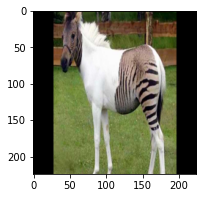

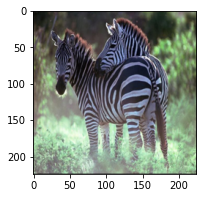

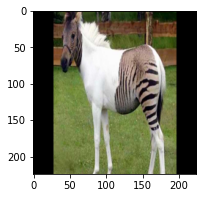

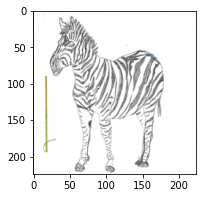

Input:     I am thinking of an animal. It is black and white. It's similar to a horse. What is it?
FROMAGe:   A zebra [RET]
Input:     That's right, what do zebras look like?
FROMAGe:   They have stripes [RET]
Input:     Show me an illustration of a zebra
FROMAGe:   [RET]
Input:     Yes, what about a pencil drawing of one?
FROMAGe:   [RET]
Input:     What about a photo of one?
FROMAGe:   [RET]


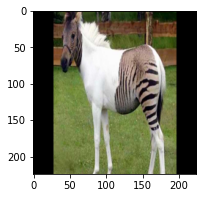

In [6]:
#!g2.1
ret_scale_factor = 1.3  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.


input_prompts = [
    "I am thinking of an animal. It is black and white. It's similar to a horse. What is it?",  # Initial prompt.
    "That's right, what do zebras look like?",
    "Show me an illustration of a zebra",
    "Yes, what about a pencil drawing of one?",
    "What about a photo of one?",
]


# ==============================================
# Code below this should not need to be edited.
# ==============================================
input_context = []
all_outputs = []
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=1)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'
    
    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

#### Example #2: Диалог о собаке (image-text inputs, image-text outputs)


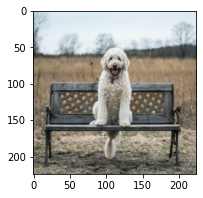

Input:     What is this image?
FROMAGe:   This is a dog sitting on a bench.
Input:     Is the image in color?
FROMAGe:   No, it is black and white.
Input:     Where do you think it was taken?
FROMAGe:   It was taken in a park.
Input:     What about a photo of similar dogs?
FROMAGe:   I have not seen any similar dogs.
Input:     Show me any other dog
FROMAGe:   I have not seen any other dog.


In [25]:
#!g2.1
ret_scale_factor = 1.0  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this image?",
    "Is the image in color?",
    "Where do you think it was taken?",
    "What about a photo of similar dogs?",
    "Show me any other dog"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'
    
    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

#### Example #3: Опять о собаке (image-text inputs, image-text outputs)


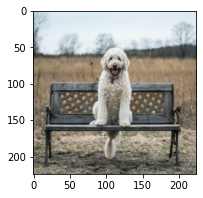

Input:     What is this?
FROMAGe:   This is a dog.
Input:     Where would this look good in?
FROMAGe:   Anywhere.


In [20]:
#!g2.1
ret_scale_factor = 0.5  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this?",
    "Where would this look good in?"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'
    
    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

Не совсем получился мультимодальный диалог. Сказывается все-таки ограиченность выборки для обучения, модель не знает собаку и не хочет генерировать дополнительные рисунки.

# Получение визуальных эмбеиннгов для обучающей выборки

Для использования обученной модели в инференсе требуются эмббедингы всей обучающей выборки, так как модель не генерирует новые изображения, а ретривит наиболее подходящей. В рамках моего эксперимента модель не сможет доучиться, поэтому я немного облегчила себе работу и создала эмббединги уже из готовой модели. По правилам их нужно было бы сделать после обучения, но так как я не доучу модель, то пойду этим путем

In [16]:
#!g2.1
from datasets import load_from_disk
reloaded_encoded_dataset = load_from_disk("filtered.hf")
reloaded_encoded_dataset

Dataset({
    features: ['image_url', 'caption', 'image'],
    num_rows: 372
})

In [17]:
#!g2.1
from transformers import AutoFeatureExtractor
visual_encoder = 'openai/clip-vit-large-patch14'
feature_extractor = AutoFeatureExtractor.from_pretrained(visual_encoder, train = False)

In [18]:
#!g2.1
import torch
from fromage import models, utils

from PIL import Image
import os
import requests
from io import BytesIO
import pickle as pkl


def extract_embeddings_for_urls(image_list: list[str],emb_output_path: str, device: str = "cuda"):


    output_data = { "embeddings": []}
    with torch.no_grad():
        for img in image_list:         

            img_tensor = utils.get_pixel_values_for_model(feature_extractor, img)
            img_tensor = img_tensor[None, ...].to(device).bfloat16()
            img_emb = model.model.get_visual_embs(img_tensor, mode="retrieval")
            img_emb = img_emb[0, 0, :].cpu()
            output_data["embeddings"].append(img_emb)
    
    with open(emb_output_path, "wb") as f:
        pkl.dump(output_data, f)

extract_embeddings_for_urls(reloaded_encoded_dataset['image'], "sample_emb.pkl")

In [19]:
#!g2.1
emb_matrix = []
with open("sample_emb.pkl", "rb") as wf:
    train_embs_data = pkl.load(wf)
    emb_matrix.append(train_embs_data["embeddings"])
emb_matrix = torch.stack([item for item in emb_matrix[0]])
emb_matrix.shape

torch.Size([372, 256])